取一小部分数据

In [1]:
import pandas as pd
import numpy as np

file_path = f"./datas/train.parquet/partition_id=0/part-0.parquet"
chunk = pd.read_parquet(file_path)

sample_df = chunk[chunk['symbol_id'] == 0]

Separate features and labels

In [2]:
# Separate features and responders
features = chunk.filter(regex='^feature_')
responders = chunk.filter(regex='^responder_')
weights = chunk['weight']

X = features.values  # Features for input
y = responders[['responder_6']].values  # Keep only responder_6
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)

LightGBM train

In [3]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, weights_train, weights_val = train_test_split(
    X, y, weights, test_size=0.2, random_state=42
)

train_data = lgb.Dataset(X_train, label=y_train, weight=weights_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6,
    'num_leaves': 63,
    'bagging_freq': 3,
    'bagging_fraction': 0.8,
    'learning_rate': 0.1,
    'verbosity': -1,
}

evals_result = {}
bst = lgb.train(params, 
                train_data, 
                num_boost_round=200, 
                valid_sets=[test_data, train_data],
                callbacks=[lgb.record_evaluation(evals_result)])

c:\Users\22123\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")
c:\Users\22123\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


Validation

<Axes: title={'center': 'rmse'}, xlabel='Iterations', ylabel='rmse'>

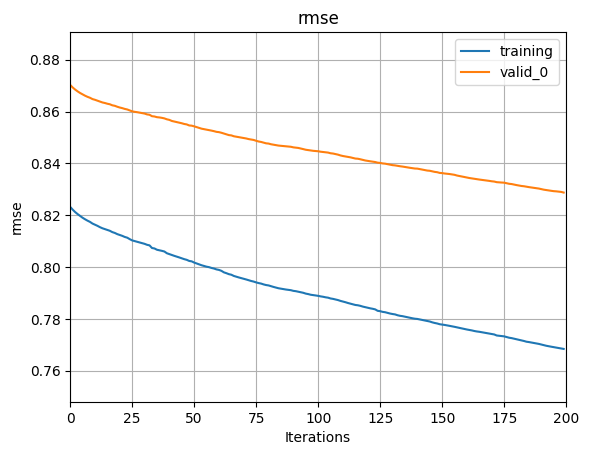

In [4]:
lgb.plot_metric(evals_result, metric='rmse', title='rmse')

Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

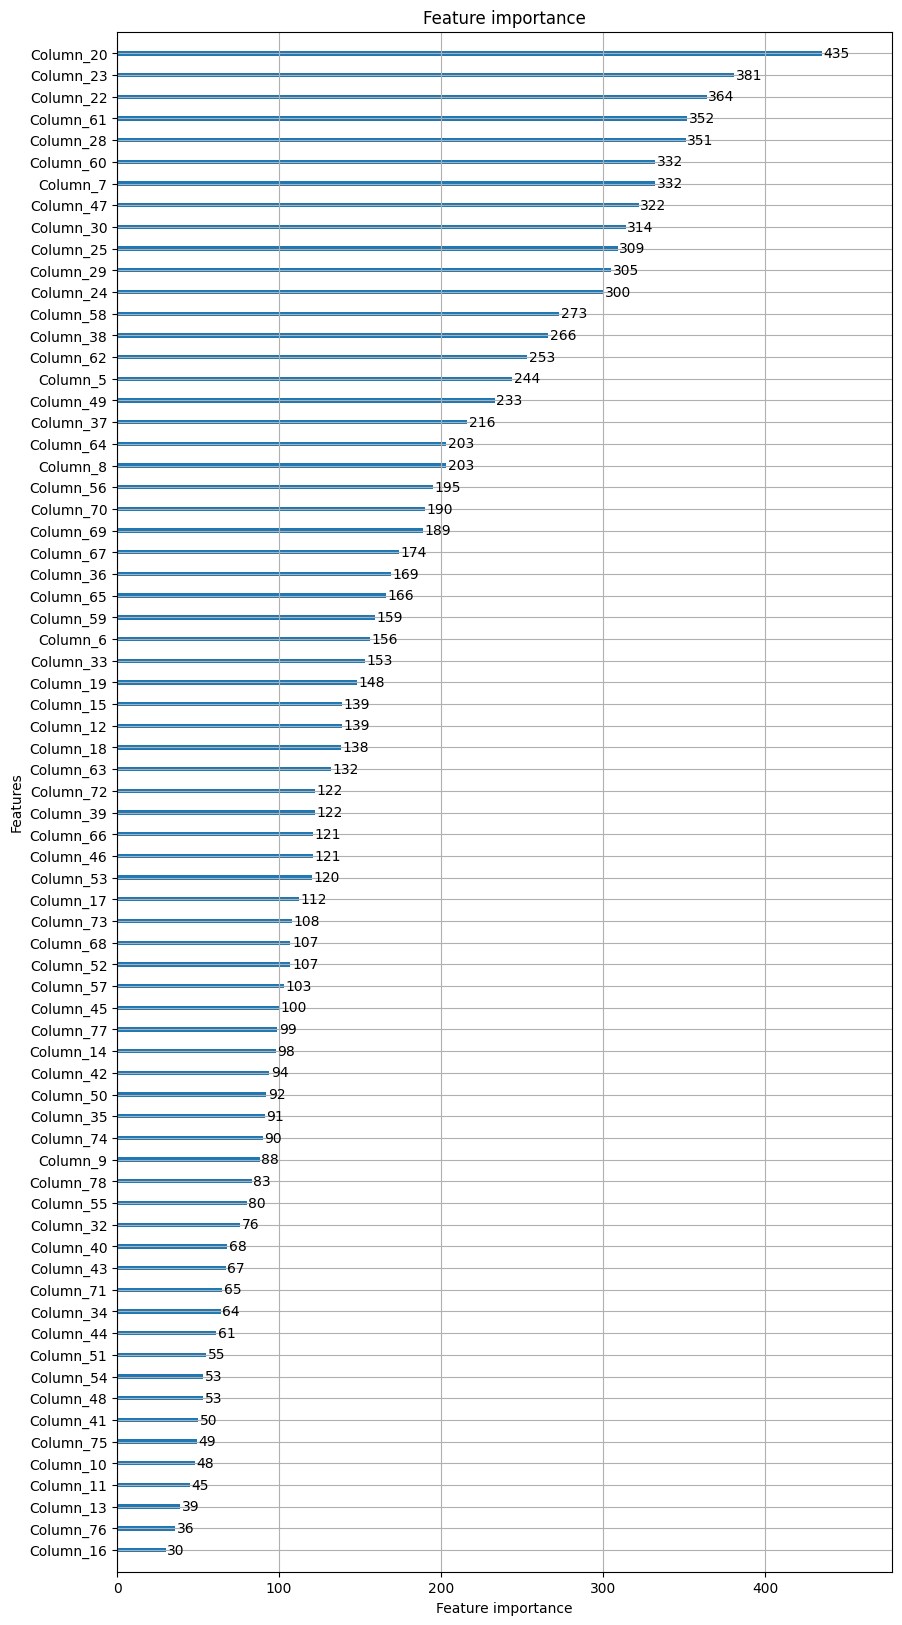

In [5]:
lgb.plot_importance(bst, figsize=(10,20))